In [1]:
from typing import List
import sys
from collections import defaultdict

import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm

from recsys4daos.models import OpenPop
from recsys4daos.datasets import to_microsoft
from recsys4daos.model_selection import cvtt_open
from recsys4daos.evaluation import calculate_all_metrics

import paths

import recommenders
if recommenders.__version__ == '1.2.0':
    print("Ignoring warnings")
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)

/tmp/ipykernel_3823990/2526015065.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Ignoring warnings


In [2]:
SPLITS_FREQ = "W-THU"
SPLITS_NORMALIZE = True
ORG_NAME = 'Decentraland'
LAST_FOLD_DATE_STR: str = None # Won't use it, we will just calculate for every fold

# In this notebook this is just used for plotting and description, not "training"
# every fold is saved into the results table
LAST_FOLDS = 10

K_RECOMMENDATIONS: List[int] = [1,3,5,10,15,100]

In [3]:
# Parameters
EXECUTION_ID = "2024-09-04T10:00"
ORG_NAME = "Bancor"
SPLITS_FREQ = "3d"
LAST_FOLDS = 10
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = "2022-01-26"


## Obtain dataset

In [4]:
!pwd

/home/daviddavo/recsys4daos/notebooks


In [5]:
!md5sum ../data/decentraland/*

md5sum: '../data/decentraland/*': No such file or directory


In [6]:
dfp = paths.load_proposals(ORG_NAME)
dfv = paths.load_votes(ORG_NAME)

df = to_microsoft(dfv)

print(dfp.info())
print(dfv.info())
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 541 non-null    object        
 1   author             541 non-null    object        
 2   date               541 non-null    datetime64[us]
 3   start              541 non-null    datetime64[us]
 4   end                541 non-null    datetime64[us]
 5   platform_proposal  541 non-null    object        
dtypes: datetime64[us](3), object(3)
memory usage: 25.5+ KB


None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30942 entries, 0 to 30941
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        30942 non-null  object        
 1   proposal  30942 non-null  object        
 2   voter     30942 non-null  object        
 3   date      30942 non-null  datetime64[us]
dtypes: datetime64[us](1), object(3)
memory usage: 967.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30942 entries, 0 to 30941
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   userID     30942 non-null  object        
 1   itemID     30942 non-null  object        
 2   timestamp  30942 non-null  datetime64[us]
 3   rating     30942 non-null  int64         
dtypes: datetime64[us](1), int64(1), object(2)
memory usage: 967.1+ KB
None


## Showing some info of the folds

In [7]:
sdd = defaultdict(list)

for dftrain, dftest, t, openproposals in cvtt_open(to_microsoft(dfv), SPLITS_FREQ, dfp.reset_index(), remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE):
    dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
    
    sdd['fold'].append(t)
    sdd['open proposals'].append(len(openproposals))
    
    sdd['proposals in train'].append(dftrain['itemID'].nunique())
    sdd['votes in train'].append(len(dftrain))
    sdd['votes in open proposals (train)'].append(len(dftrain_filter))
    sdd['users in open proposals (train)'].append(dftrain_filter['userID'].nunique())
    sdd['votes in test'].append(len(dftest))
    sdd['users in train'].append(dftrain['userID'].nunique())
    sdd['users in test'].append(dftest['userID'].nunique())

sdf_all = pd.DataFrame(sdd).set_index('fold')
sdf_all['vpp in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['open proposals']
sdf_all['vpu in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['users in open proposals (train)']
sdf_all['vpp test'] = sdf_all['votes in test'] / sdf_all['open proposals']
sdf_all['vpu test'] = sdf_all['votes in test'] / sdf_all['users in test']
paths.save_folds_info(sdf_all, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
sdf = sdf_all.tail(LAST_FOLDS)
print(sdf['votes in train'])
_style = sdf[['open proposals', 'votes in open proposals (train)', 'users in open proposals (train)', 'vpp in open proposals (train)', 'vpu in open proposals (train)', 'votes in test', 'users in test', 'vpp test', 'vpu test']].style
_style = _style.format_index('{:%G-W%V}').format(precision=2)
_style

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Bancor/baseline/folds-info_3d_normalize.parquet
fold
2023-06-20    30715
2023-06-23    30730
2023-06-26    30730
2023-06-29    30829
2023-07-02    30829
2023-07-05    30902
2023-07-08    30918
2023-07-11    30918
2023-07-14    30918
2023-07-17    30923
Name: votes in train, dtype: int64


,open proposals,votes in open proposals (train),users in open proposals (train),vpp in open proposals (train),vpu in open proposals (train),votes in test,users in test,vpp test,vpu test
fold,,,,,,,,,
2023-W25,10,87,11,8.70,7.91,15,5,1.50,3.00
2023-W25,0,0,0,nan,nan,0,0,nan,nan
2023-W26,0,0,0,nan,nan,0,0,nan,nan
2023-W26,11,99,12,9.00,8.25,0,0,0.00,nan
2023-W26,0,0,0,nan,nan,0,0,nan,nan
2023-W27,12,73,10,6.08,7.30,16,5,1.33,3.20
2023-W27,0,0,0,nan,nan,0,0,nan,nan
2023-W28,0,0,0,nan,nan,0,0,nan,nan
2023-W28,0,0,0,nan,nan,0,0,nan,nan


In [8]:
print(_style
  .format_index("\\textbf{{{}}}", escape="latex", axis=1)
  .to_latex()
)

\begin{tabular}{lrrrrrrrrr}
 & \textbf{open proposals} & \textbf{votes in open proposals (train)} & \textbf{users in open proposals (train)} & \textbf{vpp in open proposals (train)} & \textbf{vpu in open proposals (train)} & \textbf{votes in test} & \textbf{users in test} & \textbf{vpp test} & \textbf{vpu test} \\
fold &  &  &  &  &  &  &  &  &  \\
2023-W25 & 10 & 87 & 11 & 8.70 & 7.91 & 15 & 5 & 1.50 & 3.00 \\
2023-W25 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W26 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W26 & 11 & 99 & 12 & 9.00 & 8.25 & 0 & 0 & 0.00 & nan \\
2023-W26 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W27 & 12 & 73 & 10 & 6.08 & 7.30 & 16 & 5 & 1.33 & 3.20 \\
2023-W27 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W28 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W28 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W29 & 2 & 5 & 3 & 2.50 & 1.67 & 19 & 10 & 9.50 & 1.90 \\
\end{tabular}



## Running openpop baseline

In [9]:
WARNING_AT_LEAST_OPEN = 5

folds = list(cvtt_open(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE))
metrics = []
perfectmetrics = []

first_empty = True
ok_in_a_row = best_in_a_row = 0
max_ok_in_a_row = (-1, folds[-1].end)
for i, (train, test, t, open_proposals) in enumerate(tqdm(folds)):   
    if first_empty:
        if not train.empty:
            first_empty = False
    else:
        assert not train.empty, f"Train should not be empty on fold {i}"
    if test.empty:
        print(f"Warning, empty test fold {i} ({t}), all ok since {ok_in_a_row} folds ago", file=sys.stderr)
        if ok_in_a_row > max_ok_in_a_row[0]:
            max_ok_in_a_row = (ok_in_a_row, t)
        ok_in_a_row = best_in_a_row = 0
    elif len(open_proposals) < WARNING_AT_LEAST_OPEN:
        print(f"Warning, test fold {i} ({t}) with less than {WARNING_AT_LEAST_OPEN} open proposals ({len(open_proposals)}). all ok since {best_in_a_row} folds ago", file=sys.stderr)
        best_in_a_row = 0

    mdict = {'fold': t}
    pdict = {'fold': t}
    model = OpenPop(train)
    recs = model.recommend_k_items(test['userID'].unique(), max(K_RECOMMENDATIONS), recommend_from=open_proposals)
    mdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)
        # for m, f in metrics_f.items():
        #     r = f(test, recs, k=k_recs)
        #     metrics[m+f'@{k_recs}'].append(r)
    
    recs = test.copy()
    recs['prediction'] = 1
    pdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)

        # for m, f in metrics_f.items():
        #     # Need relevancy_method=None as they are unsorted
        #     r = f(test, recs, k=k_recs)
        #     perfectmetrics[m+f'@{k_recs}'].append(r)

    metrics.append(mdict)
    perfectmetrics.append(pdict)
    ok_in_a_row += 1
    best_in_a_row += 1

paths.save_dao_datum(ORG_NAME, 'max_ok_folds', str(max_ok_in_a_row[0]))
paths.save_dao_datum(ORG_NAME, 'max_ok_folds_date', str(max_ok_in_a_row[1]))
if max_ok_in_a_row == -1:
    print("All ok :>")
else:
    print("Max ok in a row:", max_ok_in_a_row)

  0%|          | 0/283 [00:00<?, ?it/s]

Warning, empty test fold 0 (2021-03-23 00:00:00), all ok since 0 folds ago


Warning, empty test fold 2 (2021-03-29 00:00:00), all ok since 2 folds ago
Warning, test fold 3 (2021-04-01 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 4 (2021-04-04 00:00:00), all ok since 2 folds ago


Warning, test fold 6 (2021-04-10 00:00:00) with less than 5 open proposals (1). all ok since 2 folds ago


Warning, test fold 7 (2021-04-13 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 8 (2021-04-16 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 9 (2021-04-19 00:00:00), all ok since 5 folds ago


Warning, empty test fold 11 (2021-04-25 00:00:00), all ok since 2 folds ago


Warning, empty test fold 13 (2021-05-01 00:00:00), all ok since 2 folds ago


Warning, empty test fold 15 (2021-05-07 00:00:00), all ok since 2 folds ago
Warning, empty test fold 16 (2021-05-10 00:00:00), all ok since 1 folds ago


Warning, empty test fold 18 (2021-05-16 00:00:00), all ok since 2 folds ago


Warning, empty test fold 20 (2021-05-22 00:00:00), all ok since 2 folds ago


Warning, test fold 22 (2021-05-28 00:00:00) with less than 5 open proposals (4). all ok since 2 folds ago


Warning, empty test fold 23 (2021-05-31 00:00:00), all ok since 3 folds ago


Warning, empty test fold 25 (2021-06-06 00:00:00), all ok since 2 folds ago


Warning, empty test fold 27 (2021-06-12 00:00:00), all ok since 2 folds ago


Warning, empty test fold 29 (2021-06-18 00:00:00), all ok since 2 folds ago
Warning, empty test fold 30 (2021-06-21 00:00:00), all ok since 1 folds ago


Warning, empty test fold 32 (2021-06-27 00:00:00), all ok since 2 folds ago


Warning, empty test fold 34 (2021-07-03 00:00:00), all ok since 2 folds ago


Warning, empty test fold 36 (2021-07-09 00:00:00), all ok since 2 folds ago
Warning, test fold 37 (2021-07-12 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 39 (2021-07-18 00:00:00), all ok since 3 folds ago


Warning, empty test fold 41 (2021-07-24 00:00:00), all ok since 2 folds ago


Warning, empty test fold 43 (2021-07-30 00:00:00), all ok since 2 folds ago
Warning, empty test fold 44 (2021-08-02 00:00:00), all ok since 1 folds ago


Warning, empty test fold 46 (2021-08-08 00:00:00), all ok since 2 folds ago


Warning, empty test fold 48 (2021-08-14 00:00:00), all ok since 2 folds ago


Warning, empty test fold 50 (2021-08-20 00:00:00), all ok since 2 folds ago


Warning, test fold 52 (2021-08-26 00:00:00) with less than 5 open proposals (1). all ok since 2 folds ago


Warning, empty test fold 53 (2021-08-29 00:00:00), all ok since 3 folds ago
Warning, test fold 54 (2021-09-01 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 55 (2021-09-04 00:00:00), all ok since 2 folds ago


Warning, empty test fold 57 (2021-09-10 00:00:00), all ok since 2 folds ago


Warning, empty test fold 59 (2021-09-16 00:00:00), all ok since 2 folds ago
Warning, empty test fold 60 (2021-09-19 00:00:00), all ok since 1 folds ago


Warning, test fold 61 (2021-09-22 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 62 (2021-09-25 00:00:00), all ok since 2 folds ago
Warning, empty test fold 63 (2021-09-28 00:00:00), all ok since 1 folds ago


Warning, empty test fold 64 (2021-10-01 00:00:00), all ok since 1 folds ago
Warning, test fold 65 (2021-10-04 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 66 (2021-10-07 00:00:00), all ok since 2 folds ago
Warning, empty test fold 67 (2021-10-10 00:00:00), all ok since 1 folds ago


Warning, empty test fold 69 (2021-10-16 00:00:00), all ok since 2 folds ago
Warning, test fold 70 (2021-10-19 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 71 (2021-10-22 00:00:00), all ok since 2 folds ago
Warning, test fold 72 (2021-10-25 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 73 (2021-10-28 00:00:00), all ok since 2 folds ago
Warning, empty test fold 74 (2021-10-31 00:00:00), all ok since 1 folds ago


Warning, test fold 75 (2021-11-03 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 76 (2021-11-06 00:00:00), all ok since 2 folds ago
Warning, test fold 77 (2021-11-09 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 78 (2021-11-12 00:00:00), all ok since 2 folds ago


Warning, empty test fold 80 (2021-11-18 00:00:00), all ok since 2 folds ago
Warning, empty test fold 81 (2021-11-21 00:00:00), all ok since 1 folds ago


Warning, test fold 82 (2021-11-24 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 83 (2021-11-27 00:00:00), all ok since 2 folds ago
Warning, test fold 84 (2021-11-30 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 85 (2021-12-03 00:00:00), all ok since 2 folds ago
Warning, test fold 86 (2021-12-06 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 87 (2021-12-09 00:00:00), all ok since 2 folds ago
Warning, empty test fold 88 (2021-12-12 00:00:00), all ok since 1 folds ago


Warning, test fold 89 (2021-12-15 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 90 (2021-12-18 00:00:00), all ok since 2 folds ago


Warning, empty test fold 92 (2021-12-24 00:00:00), all ok since 2 folds ago


Warning, empty test fold 94 (2021-12-30 00:00:00), all ok since 2 folds ago
Warning, empty test fold 95 (2022-01-02 00:00:00), all ok since 1 folds ago


Warning, empty test fold 97 (2022-01-08 00:00:00), all ok since 2 folds ago


Warning, empty test fold 99 (2022-01-14 00:00:00), all ok since 2 folds ago


Warning, empty test fold 101 (2022-01-20 00:00:00), all ok since 2 folds ago
Warning, empty test fold 102 (2022-01-23 00:00:00), all ok since 1 folds ago


Warning, test fold 103 (2022-01-26 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 104 (2022-01-29 00:00:00), all ok since 2 folds ago


Warning, empty test fold 106 (2022-02-04 00:00:00), all ok since 2 folds ago


Warning, empty test fold 108 (2022-02-10 00:00:00), all ok since 2 folds ago
Warning, empty test fold 109 (2022-02-13 00:00:00), all ok since 1 folds ago


Warning, empty test fold 111 (2022-02-19 00:00:00), all ok since 2 folds ago
Warning, test fold 112 (2022-02-22 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 113 (2022-02-25 00:00:00), all ok since 2 folds ago
Warning, test fold 114 (2022-02-28 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 115 (2022-03-03 00:00:00), all ok since 2 folds ago
Warning, empty test fold 116 (2022-03-06 00:00:00), all ok since 1 folds ago


Warning, test fold 117 (2022-03-09 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 118 (2022-03-12 00:00:00), all ok since 2 folds ago
Warning, test fold 119 (2022-03-15 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 120 (2022-03-18 00:00:00), all ok since 2 folds ago
Warning, empty test fold 121 (2022-03-21 00:00:00), all ok since 1 folds ago


Warning, empty test fold 122 (2022-03-24 00:00:00), all ok since 1 folds ago
Warning, empty test fold 123 (2022-03-27 00:00:00), all ok since 1 folds ago


Warning, test fold 124 (2022-03-30 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 125 (2022-04-02 00:00:00), all ok since 2 folds ago


Warning, empty test fold 127 (2022-04-08 00:00:00), all ok since 2 folds ago
Warning, empty test fold 128 (2022-04-11 00:00:00), all ok since 1 folds ago


Warning, empty test fold 130 (2022-04-17 00:00:00), all ok since 2 folds ago
Warning, test fold 131 (2022-04-20 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 132 (2022-04-23 00:00:00), all ok since 2 folds ago
Warning, test fold 133 (2022-04-26 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 134 (2022-04-29 00:00:00), all ok since 2 folds ago


Warning, empty test fold 136 (2022-05-05 00:00:00), all ok since 2 folds ago
Warning, test fold 137 (2022-05-08 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 139 (2022-05-14 00:00:00), all ok since 3 folds ago
Warning, test fold 140 (2022-05-17 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 141 (2022-05-20 00:00:00), all ok since 2 folds ago
Warning, test fold 142 (2022-05-23 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 143 (2022-05-26 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 144 (2022-05-29 00:00:00), all ok since 3 folds ago
Warning, test fold 145 (2022-06-01 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 146 (2022-06-04 00:00:00), all ok since 2 folds ago
Warning, test fold 147 (2022-06-07 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 148 (2022-06-10 00:00:00), all ok since 2 folds ago
Warning, test fold 149 (2022-06-13 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 150 (2022-06-16 00:00:00), all ok since 2 folds ago
Warning, empty test fold 151 (2022-06-19 00:00:00), all ok since 1 folds ago


Warning, empty test fold 153 (2022-06-25 00:00:00), all ok since 2 folds ago
Warning, test fold 154 (2022-06-28 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 155 (2022-07-01 00:00:00), all ok since 2 folds ago
Warning, test fold 156 (2022-07-04 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 157 (2022-07-07 00:00:00), all ok since 2 folds ago
Warning, empty test fold 158 (2022-07-10 00:00:00), all ok since 1 folds ago


Warning, test fold 159 (2022-07-13 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 160 (2022-07-16 00:00:00), all ok since 2 folds ago
Warning, test fold 161 (2022-07-19 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 162 (2022-07-22 00:00:00), all ok since 2 folds ago
Warning, test fold 163 (2022-07-25 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 164 (2022-07-28 00:00:00), all ok since 2 folds ago
Warning, empty test fold 165 (2022-07-31 00:00:00), all ok since 1 folds ago


Warning, empty test fold 167 (2022-08-06 00:00:00), all ok since 2 folds ago
Warning, test fold 168 (2022-08-09 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 169 (2022-08-12 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 170 (2022-08-15 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 171 (2022-08-18 00:00:00), all ok since 4 folds ago
Warning, empty test fold 172 (2022-08-21 00:00:00), all ok since 1 folds ago


Warning, empty test fold 173 (2022-08-24 00:00:00), all ok since 1 folds ago
Warning, empty test fold 174 (2022-08-27 00:00:00), all ok since 1 folds ago


Warning, test fold 175 (2022-08-30 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 176 (2022-09-02 00:00:00), all ok since 2 folds ago
Warning, test fold 177 (2022-09-05 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 178 (2022-09-08 00:00:00), all ok since 2 folds ago
Warning, empty test fold 179 (2022-09-11 00:00:00), all ok since 1 folds ago


Warning, empty test fold 180 (2022-09-14 00:00:00), all ok since 1 folds ago
Warning, empty test fold 181 (2022-09-17 00:00:00), all ok since 1 folds ago


Warning, empty test fold 182 (2022-09-20 00:00:00), all ok since 1 folds ago
Warning, empty test fold 183 (2022-09-23 00:00:00), all ok since 1 folds ago


Warning, test fold 184 (2022-09-26 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 185 (2022-09-29 00:00:00), all ok since 2 folds ago
Warning, empty test fold 186 (2022-10-02 00:00:00), all ok since 1 folds ago


Warning, empty test fold 187 (2022-10-05 00:00:00), all ok since 1 folds ago
Warning, empty test fold 188 (2022-10-08 00:00:00), all ok since 1 folds ago


Warning, test fold 189 (2022-10-11 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 190 (2022-10-14 00:00:00), all ok since 2 folds ago
Warning, test fold 191 (2022-10-17 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 192 (2022-10-20 00:00:00), all ok since 2 folds ago
Warning, empty test fold 193 (2022-10-23 00:00:00), all ok since 1 folds ago


Warning, empty test fold 194 (2022-10-26 00:00:00), all ok since 1 folds ago
Warning, empty test fold 195 (2022-10-29 00:00:00), all ok since 1 folds ago


Warning, empty test fold 196 (2022-11-01 00:00:00), all ok since 1 folds ago
Warning, empty test fold 197 (2022-11-04 00:00:00), all ok since 1 folds ago


Warning, empty test fold 198 (2022-11-07 00:00:00), all ok since 1 folds ago
Warning, empty test fold 199 (2022-11-10 00:00:00), all ok since 1 folds ago


Warning, empty test fold 200 (2022-11-13 00:00:00), all ok since 1 folds ago
Warning, test fold 201 (2022-11-16 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 202 (2022-11-19 00:00:00), all ok since 2 folds ago
Warning, empty test fold 203 (2022-11-22 00:00:00), all ok since 1 folds ago


Warning, empty test fold 204 (2022-11-25 00:00:00), all ok since 1 folds ago
Warning, empty test fold 205 (2022-11-28 00:00:00), all ok since 1 folds ago


Warning, empty test fold 206 (2022-12-01 00:00:00), all ok since 1 folds ago
Warning, empty test fold 207 (2022-12-04 00:00:00), all ok since 1 folds ago


Warning, empty test fold 208 (2022-12-07 00:00:00), all ok since 1 folds ago
Warning, empty test fold 209 (2022-12-10 00:00:00), all ok since 1 folds ago


Warning, empty test fold 210 (2022-12-13 00:00:00), all ok since 1 folds ago
Warning, test fold 211 (2022-12-16 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 212 (2022-12-19 00:00:00), all ok since 2 folds ago
Warning, empty test fold 213 (2022-12-22 00:00:00), all ok since 1 folds ago


Warning, empty test fold 214 (2022-12-25 00:00:00), all ok since 1 folds ago
Warning, empty test fold 215 (2022-12-28 00:00:00), all ok since 1 folds ago


Warning, empty test fold 216 (2022-12-31 00:00:00), all ok since 1 folds ago
Warning, empty test fold 217 (2023-01-03 00:00:00), all ok since 1 folds ago


Warning, empty test fold 218 (2023-01-06 00:00:00), all ok since 1 folds ago
Warning, empty test fold 219 (2023-01-09 00:00:00), all ok since 1 folds ago


Warning, empty test fold 220 (2023-01-12 00:00:00), all ok since 1 folds ago
Warning, empty test fold 221 (2023-01-15 00:00:00), all ok since 1 folds ago


Warning, empty test fold 222 (2023-01-18 00:00:00), all ok since 1 folds ago
Warning, empty test fold 223 (2023-01-21 00:00:00), all ok since 1 folds ago


Warning, empty test fold 224 (2023-01-24 00:00:00), all ok since 1 folds ago
Warning, empty test fold 225 (2023-01-27 00:00:00), all ok since 1 folds ago


Warning, empty test fold 226 (2023-01-30 00:00:00), all ok since 1 folds ago
Warning, empty test fold 227 (2023-02-02 00:00:00), all ok since 1 folds ago


Warning, empty test fold 228 (2023-02-05 00:00:00), all ok since 1 folds ago
Warning, test fold 229 (2023-02-08 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 230 (2023-02-11 00:00:00), all ok since 2 folds ago
Warning, empty test fold 231 (2023-02-14 00:00:00), all ok since 1 folds ago


Warning, empty test fold 232 (2023-02-17 00:00:00), all ok since 1 folds ago
Warning, empty test fold 233 (2023-02-20 00:00:00), all ok since 1 folds ago


Warning, test fold 234 (2023-02-23 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 235 (2023-02-26 00:00:00), all ok since 2 folds ago
Warning, empty test fold 236 (2023-03-01 00:00:00), all ok since 1 folds ago


Warning, empty test fold 237 (2023-03-04 00:00:00), all ok since 1 folds ago
Warning, empty test fold 238 (2023-03-07 00:00:00), all ok since 1 folds ago


Warning, empty test fold 239 (2023-03-10 00:00:00), all ok since 1 folds ago
Warning, empty test fold 240 (2023-03-13 00:00:00), all ok since 1 folds ago


Warning, empty test fold 241 (2023-03-16 00:00:00), all ok since 1 folds ago
Warning, empty test fold 242 (2023-03-19 00:00:00), all ok since 1 folds ago


Warning, empty test fold 243 (2023-03-22 00:00:00), all ok since 1 folds ago
Warning, test fold 244 (2023-03-25 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 245 (2023-03-28 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 246 (2023-03-31 00:00:00), all ok since 3 folds ago
Warning, empty test fold 247 (2023-04-03 00:00:00), all ok since 1 folds ago


Warning, empty test fold 248 (2023-04-06 00:00:00), all ok since 1 folds ago
Warning, empty test fold 249 (2023-04-09 00:00:00), all ok since 1 folds ago


Warning, empty test fold 250 (2023-04-12 00:00:00), all ok since 1 folds ago
Warning, empty test fold 251 (2023-04-15 00:00:00), all ok since 1 folds ago


Warning, test fold 253 (2023-04-21 00:00:00) with less than 5 open proposals (1). all ok since 2 folds ago


Warning, empty test fold 254 (2023-04-24 00:00:00), all ok since 3 folds ago
Warning, empty test fold 255 (2023-04-27 00:00:00), all ok since 1 folds ago


Warning, empty test fold 256 (2023-04-30 00:00:00), all ok since 1 folds ago
Warning, empty test fold 257 (2023-05-03 00:00:00), all ok since 1 folds ago


Warning, empty test fold 258 (2023-05-06 00:00:00), all ok since 1 folds ago
Warning, empty test fold 259 (2023-05-09 00:00:00), all ok since 1 folds ago


Warning, empty test fold 260 (2023-05-12 00:00:00), all ok since 1 folds ago
Warning, empty test fold 261 (2023-05-15 00:00:00), all ok since 1 folds ago


Warning, test fold 262 (2023-05-18 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 263 (2023-05-21 00:00:00), all ok since 2 folds ago
Warning, empty test fold 264 (2023-05-24 00:00:00), all ok since 1 folds ago


Warning, empty test fold 265 (2023-05-27 00:00:00), all ok since 1 folds ago
Warning, empty test fold 266 (2023-05-30 00:00:00), all ok since 1 folds ago


Warning, empty test fold 267 (2023-06-02 00:00:00), all ok since 1 folds ago


Warning, empty test fold 269 (2023-06-08 00:00:00), all ok since 2 folds ago
Warning, empty test fold 270 (2023-06-11 00:00:00), all ok since 1 folds ago


Warning, empty test fold 272 (2023-06-17 00:00:00), all ok since 2 folds ago


Warning, empty test fold 274 (2023-06-23 00:00:00), all ok since 2 folds ago
Warning, empty test fold 275 (2023-06-26 00:00:00), all ok since 1 folds ago


Warning, empty test fold 276 (2023-06-29 00:00:00), all ok since 1 folds ago
Warning, empty test fold 277 (2023-07-02 00:00:00), all ok since 1 folds ago


Warning, empty test fold 279 (2023-07-08 00:00:00), all ok since 2 folds ago
Warning, empty test fold 280 (2023-07-11 00:00:00), all ok since 1 folds ago


Warning, empty test fold 281 (2023-07-14 00:00:00), all ok since 1 folds ago
Warning, test fold 282 (2023-07-17 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Max ok in a row: (5, Timestamp('2021-04-19 00:00:00'))


### Caching these results

In [10]:
odf = pd.DataFrame(metrics).set_index("fold")
paths.save_openpop(odf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
odf.describe()

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Bancor/baseline/openpop_3d_normalize.parquet


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,...,283.000000,283.000000,283.00000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000
mean,0.293094,0.213172,0.169947,0.106717,0.073611,0.011043,0.293094,0.308529,0.314225,0.320092,...,0.341603,0.346259,0.34629,0.180302,0.263546,0.297080,0.322903,0.325622,0.325622,0.091113
std,0.418294,0.317710,0.270894,0.182795,0.128636,0.019297,0.418294,0.432724,0.439106,0.444680,...,0.471139,0.476588,0.47663,0.305161,0.390347,0.421095,0.447192,0.450084,0.450084,0.031117
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.067940
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069533
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070972
75%,0.792857,0.410145,0.307143,0.158571,0.105714,0.015857,0.792857,0.854757,0.884258,0.903735,...,1.000000,1.000000,1.00000,0.288675,0.552643,0.740267,0.907533,0.909875,0.909875,0.123719
max,1.000000,0.933333,0.893333,0.795455,0.616667,0.092500,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.310119


In [11]:
pdf = pd.DataFrame(perfectmetrics).set_index("fold")
cols = [ c for c in pdf.columns if not c.startswith('time_') ]
paths.save_perfect(pdf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
display(pdf.describe())
msk = (0 <= pdf[cols].min()) & (pdf[cols].max() <= 1)
if not all(msk):
    display(pdf.describe()[msk[~msk].index])
assert all( msk ), "There are metrics with wrong range"

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Bancor/baseline/perfect_3d_normalize.parquet


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,...,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000
mean,0.349823,0.232798,0.179391,0.107995,0.073856,0.011078,0.349823,0.349823,0.349823,0.349823,...,0.347659,0.349823,0.349823,0.204521,0.294960,0.326452,0.347659,0.349823,0.349823,0.095281
std,0.477759,0.344531,0.284809,0.184474,0.128574,0.019286,0.477759,0.477759,0.477759,0.477759,...,0.475017,0.477759,0.477759,0.322247,0.416446,0.449984,0.475017,0.477759,0.477759,0.029485
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071955
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.073386
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.074554
75%,1.000000,0.528571,0.317143,0.158571,0.105714,0.015857,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.390598,0.717266,0.894841,1.000000,1.000000,1.000000,0.129697
max,1.000000,1.000000,0.946667,0.804545,0.616667,0.092500,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.166540


## Plotting some graphs

,fold,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,283,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,...,283.00000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,0.0,0.0
mean,2022-05-20 00:00:00,0.293094,0.213172,0.169947,0.106717,0.073611,0.011043,0.293094,0.308529,0.314225,...,0.34629,0.180302,0.263546,0.297080,0.322903,0.325622,0.325622,0.091113,NaN,NaN
min,2021-03-23 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.067940,NaN,NaN
25%,2021-10-20 12:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069533,NaN,NaN
50%,2022-05-20 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070972,NaN,NaN
75%,2022-12-17 12:00:00,0.792857,0.410145,0.307143,0.158571,0.105714,0.015857,0.792857,0.854757,0.884258,...,1.00000,0.288675,0.552643,0.740267,0.907533,0.909875,0.909875,0.123719,NaN,NaN
max,2023-07-17 00:00:00,1.000000,0.933333,0.893333,0.795455,0.616667,0.092500,1.000000,1.000000,1.000000,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.310119,NaN,NaN
std,NaN,0.418294,0.317710,0.270894,0.182795,0.128636,0.019297,0.418294,0.432724,0.439106,...,0.47663,0.305161,0.390347,0.421095,0.447192,0.450084,0.450084,0.031117,NaN,NaN


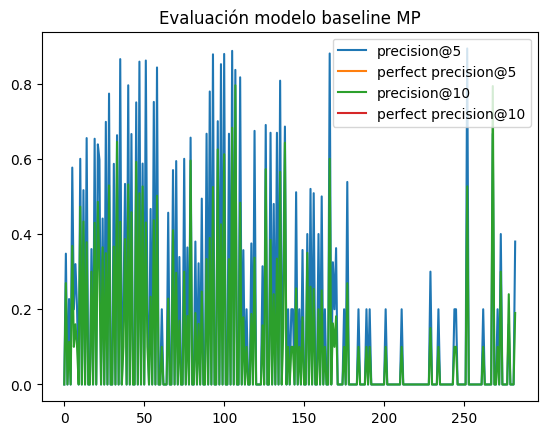

In [12]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = pdf['precision@5']
mdf['perfect precision@10'] = pdf['precision@10']
mdf[['precision@5', 'perfect precision@5', 'precision@10', 'perfect precision@10']].plot(title='Evaluación modelo baseline MP')
mdf.describe()

In [13]:
mdf[-LAST_FOLDS:].describe()

,fold,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,10,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.0,0.0
mean,2023-07-03 12:00:00,0.170000,0.136667,0.094000,0.073000,0.054000,0.008100,0.170000,0.201546,0.198922,...,0.300000,0.115833,0.214167,0.233333,0.287500,0.287500,0.287500,0.086157,NaN,NaN
min,2023-06-20 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069095,NaN,NaN
25%,2023-06-26 18:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069560,NaN,NaN
50%,2023-07-03 12:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069808,NaN,NaN
75%,2023-07-10 06:00:00,0.150000,0.150000,0.120000,0.142500,0.095000,0.014250,0.150000,0.150000,0.130319,...,0.750000,0.093750,0.281250,0.375000,0.656250,0.656250,0.656250,0.110535,NaN,NaN
max,2023-07-17 00:00:00,0.900000,0.633333,0.400000,0.300000,0.213333,0.032000,0.900000,0.963093,0.963093,...,1.000000,0.533333,1.000000,1.000000,1.000000,1.000000,1.000000,0.125311,NaN,NaN
std,NaN,0.319896,0.244672,0.163856,0.120374,0.089688,0.013453,0.319896,0.378282,0.378385,...,0.483046,0.214967,0.375608,0.394405,0.464167,0.464167,0.464167,0.026707,NaN,NaN
